# ***Project 2 - CS 579 Online Social Network Analysis***
******
***Fateen Ahmed***
***CWID: A20545670***
******


The selected dataset represents a network of subreddit-to-subreddit hyperlinks extracted from Reddit posts, comprising two distinct files:

1. **Body Dataset:**
   - **File:** `soc-redditHyperlinks-body.tsv`
   - **Description:** Contains links embedded in the body text of Reddit posts.

2. **Title Dataset:**
   - **File:** `soc-redditHyperlinks-title.tsv`
   - **Description:** Contains links embedded in the titles of Reddit posts.

### Data Fields:
Each dataset contains several key fields:

1. **SOURCE_SUBREDDIT:**
   - The subreddit where the hyperlink originates.

2. **TARGET_SUBREDDIT:**
   - The subreddit where the hyperlink leads.

3. **POST_ID:**
   - The ID of the Reddit post that includes the hyperlink.

4. **TIMESTAMP:**
   - The time the post was created.

5. **LINK_SENTIMENT:**
   - Label indicating the sentiment of the post towards its target subreddit:
      - `-1` indicates a negative sentiment.
      - `1` indicates a neutral or positive sentiment.

6. **PROPERTIES:**
   - A vector of text properties related to the post's content:
      - **Character counts:** Total and without whitespace.
      - **Fractions:** Of alphabetical characters, digits, uppercase letters, white spaces, and special characters.
      - **Word counts:** Total, unique, long (6+ characters), and stopwords.
      - **Average word length:** Including stopword fractions.
      - **Sentence counts:** Total, long (10+ words), and readability index.
      - **VADER Sentiments:** Positive, negative, and compound scores.
      - **LIWC Scores:** Linguistic Inquiry and Word Count categories across a range of metrics.

### Dataset Size:
- **Body Dataset:** 286,561 records.
- **Title Dataset:** 571,927 records.

**Data Preparation:**
   - **Sampling:**
      - sampling a proportional subset from the body and title datasets, merging them into a combined dataset.
   - **Feature Selection:**
      - Relevant columns (`SOURCE_SUBREDDIT`, `TARGET_SUBREDDIT`, `POST_ID`, `TIMESTAMP`, `LINK_SENTIMENT`) are selected.

**Feature Engineering:**
   - **Sentiment Extraction:**
      - A function extracts VADER sentiment scores from the `PROPERTIES` field, including positive, negative, and compound scores.
      - The extracted scores are added back to the main dataset, removing the original properties field.

In [7]:
import pandas as pd
from IPython.display import display, HTML

# Load the files
body_path = '/content/drive/MyDrive/CS579 - Project 2/data/soc-redditHyperlinks-body.tsv'
title_path = '/content/drive/MyDrive/CS579 - Project 2/data/soc-redditHyperlinks-title.tsv'

df_body = pd.read_csv(body_path, sep='\t')
df_title = pd.read_csv(title_path, sep='\t')

# Display the first few rows
body_html = df_body.head().to_html()
title_html = df_title.head().to_html()

print("Body Dataset:")
display(HTML(body_html))

print("Title Dataset:")
display(HTML(title_html))

# Check the number of records
print("Number of records in the body dataset:", len(df_body))
print("Number of records in the title dataset:", len(df_title))

Body Dataset:


Title Dataset:


Number of records in the body dataset: 286561
Number of records in the title dataset: 571927


In [14]:
# Proportional sample sizes
body_sample_size = 3340
title_sample_size = 6660

# Create the samples
df_body_sample = df_body.sample(n=body_sample_size, random_state=42)
df_title_sample = df_title.sample(n=title_sample_size, random_state=42)

# Combine the samples
df_combined = pd.concat([df_body_sample, df_title_sample]).reset_index(drop=True)

# Extract relevant features
df_combined = df_combined[['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'POST_ID', 'TIMESTAMP', 'LINK_SENTIMENT', 'PROPERTIES']]

# Feature engineering for specific POST_PROPERTIES
def extract_properties(properties_string):
    properties_list = list(map(float, properties_string.split(',')))
    return properties_list[19:22]  # VADER sentiment scores (positive, negative, compound)

# Applying feature extraction
properties_df = df_combined['PROPERTIES'].apply(extract_properties)
properties_df = pd.DataFrame(properties_df.tolist(), columns=['VADER_Positive', 'VADER_Negative', 'VADER_Compound'])

# Combine back into the main dataframe
df_combined = pd.concat([df_combined, properties_df], axis=1)

# Remove the original PROPERTIES column
df_combined = df_combined.drop(columns=['PROPERTIES'])

# Display information about the combined dataset
print("Combined Sample Info:")
print(df_combined.info())

df_combined_html = df_combined.head().to_html()
display(HTML(df_combined_html))

Combined Sample Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SOURCE_SUBREDDIT  10000 non-null  object 
 1   TARGET_SUBREDDIT  10000 non-null  object 
 2   POST_ID           10000 non-null  object 
 3   TIMESTAMP         10000 non-null  object 
 4   LINK_SENTIMENT    10000 non-null  int64  
 5   VADER_Positive    10000 non-null  float64
 6   VADER_Negative    10000 non-null  float64
 7   VADER_Compound    10000 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 625.1+ KB
None


**Network Generation:**
   - **Creating a Graph:**
      - Useing the `networkx` library to create a graph from the dataset, where nodes represent subreddits, and edges represent interactions.
  
**Network Visualization:**
   - **Node and Edge Rendering:**
      - Using `Plotly` to render edges between nodes and nodes themselves.
      

In [16]:
import plotly.graph_objects as go
import networkx as nx

# Create a graph from the combined dataset
G = nx.from_pandas_edgelist(df_combined, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Positions for each node
pos = nx.spring_layout(G, scale=1)

# Extract edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create nodes
node_x = []
node_y = []
node_colors = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Count the number of neighbors to color the nodes
    node_colors.append(len(list(G.neighbors(node))))
    # Text info for each node
    node_text.append(f"Node: {node}, Connections: {len(list(G.neighbors(node)))}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlOrRd',
        color=node_colors,
        size=8,
        colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')
    ),
    text=node_text
)

# Create final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Network Visualization',
                                 showlegend=False,
                                 hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [18]:
# Save the Plotly figure as an HTML file
fig.write_html('network_visualization_spring.html')

In [19]:
import plotly.graph_objects as go
import networkx as nx

# Create a graph from the combined dataset
G = nx.from_pandas_edgelist(df_combined, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Testing different layouts
def visualize_network(G, layout):
    # Create positions based on the selected layout
    if layout == 'spring':
        pos = nx.spring_layout(G, scale=1)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G)
    else:
        raise ValueError("Invalid layout type specified.")

    # Extract edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    # Create nodes
    node_x = []
    node_y = []
    node_colors = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_colors.append(len(list(G.neighbors(node))))
        node_text.append(f"Node: {node}, Connections: {len(list(G.neighbors(node)))}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlOrRd',
            color=node_colors,
            size=8,
            colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')
        ),
        text=node_text
    )

    # Create final figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(title=f'Network Visualization ({layout} layout)',
                                     showlegend=False,
                                     hovermode='closest',
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    fig.show()

# Visualize the network with different layouts
visualize_network(G, 'spring')
visualize_network(G, 'kamada_kawai')
visualize_network(G, 'circular')

Output hidden; open in https://colab.research.google.com to view.

## *Perfoming Exploratory Data Analysis*

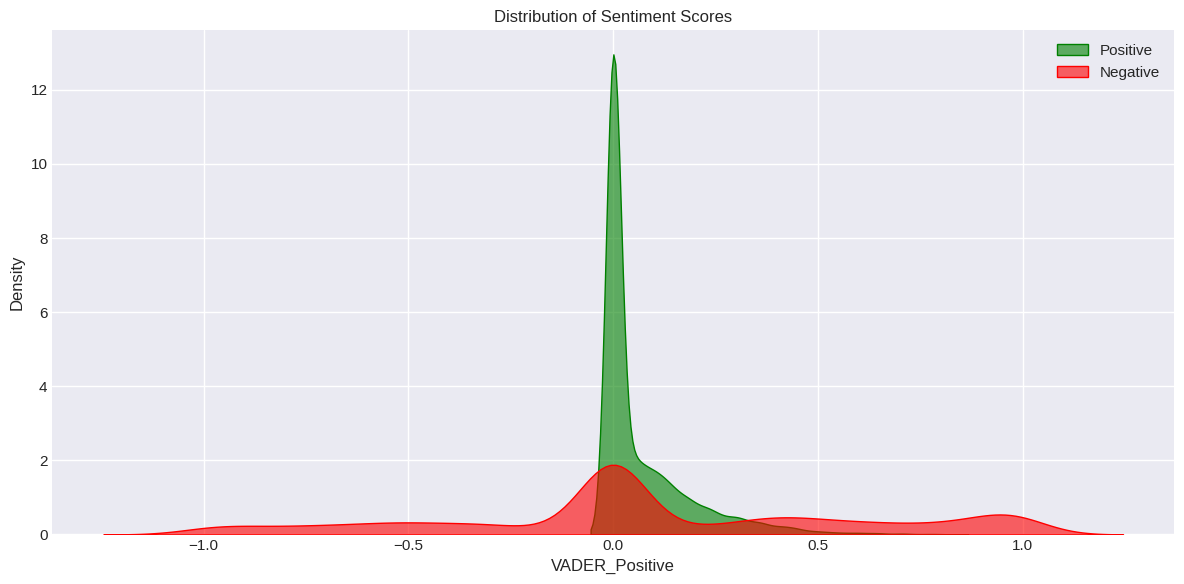

In [26]:
plt.figure(figsize=(12, 6))

sns.kdeplot(df_combined['VADER_Positive'], color='green', fill=True, alpha=0.6)
sns.kdeplot(df_combined['VADER_Negative'], color='red', fill=True, alpha=0.6)
plt.title("Distribution of Sentiment Scores")
plt.legend(["Positive", "Negative"])
plt.tight_layout()

plt.show()

### Observations:

1. **Peak at Zero**: Both positive and negative sentiment distributions show a significant peak around zero, suggesting that many posts have neutral sentiment.

2. **Asymmetrical Distribution**:
   - The positive sentiment distribution (green) leans slightly toward the positive side of the spectrum, indicating that a larger portion of posts convey positive or neutral sentiments.
   - The negative sentiment distribution (red) is more spread out, suggesting that while neutral sentiments are common, some posts exhibit varying degrees of negativity.

3. **Tail Behavior**: Both distributions have tails extending towards positive and negative values, reflecting a variety of posts with sentiments ranging from highly positive to strongly negative.

4. **Sentiment Balance**: The overlapping nature of the two distributions indicates that posts tend to balance out between positive and negative sentiments, with neither category dominating the dataset.

In [32]:
# Create a new DataFrame for monthly interaction volumes
interaction_volume_df = df_combined[['TIMESTAMP', 'POST_ID']]

# Convert TIMESTAMP to datetime
interaction_volume_df['TIMESTAMP'] = pd.to_datetime(interaction_volume_df['TIMESTAMP'])

# Add a 'Month' column for grouping
interaction_volume_df['Month'] = interaction_volume_df['TIMESTAMP'].dt.to_period('M')
interaction_volume_df = interaction_volume_df.groupby('Month')['POST_ID'].count().reset_index()
interaction_volume_df['Month'] = interaction_volume_df['Month'].dt.to_timestamp()

<ipython-input-32-548d272c4bf0>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-548d272c4bf0>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# Create a new DataFrame for monthly sentiment scores
sentiment_df = df_combined[['TIMESTAMP', 'VADER_Positive', 'VADER_Negative']]

# Convert TIMESTAMP to datetime
sentiment_df['TIMESTAMP'] = pd.to_datetime(sentiment_df['TIMESTAMP'])

# Add a 'Month' column for grouping
sentiment_df['Month'] = sentiment_df['TIMESTAMP'].dt.to_period('M')
sentiment_df = sentiment_df.groupby('Month').agg({
    'VADER_Positive': 'mean',
    'VADER_Negative': 'mean'
}).reset_index()
sentiment_df['Month'] = sentiment_df['Month'].dt.to_timestamp()

<ipython-input-33-bc884ff7feff>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-bc884ff7feff>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



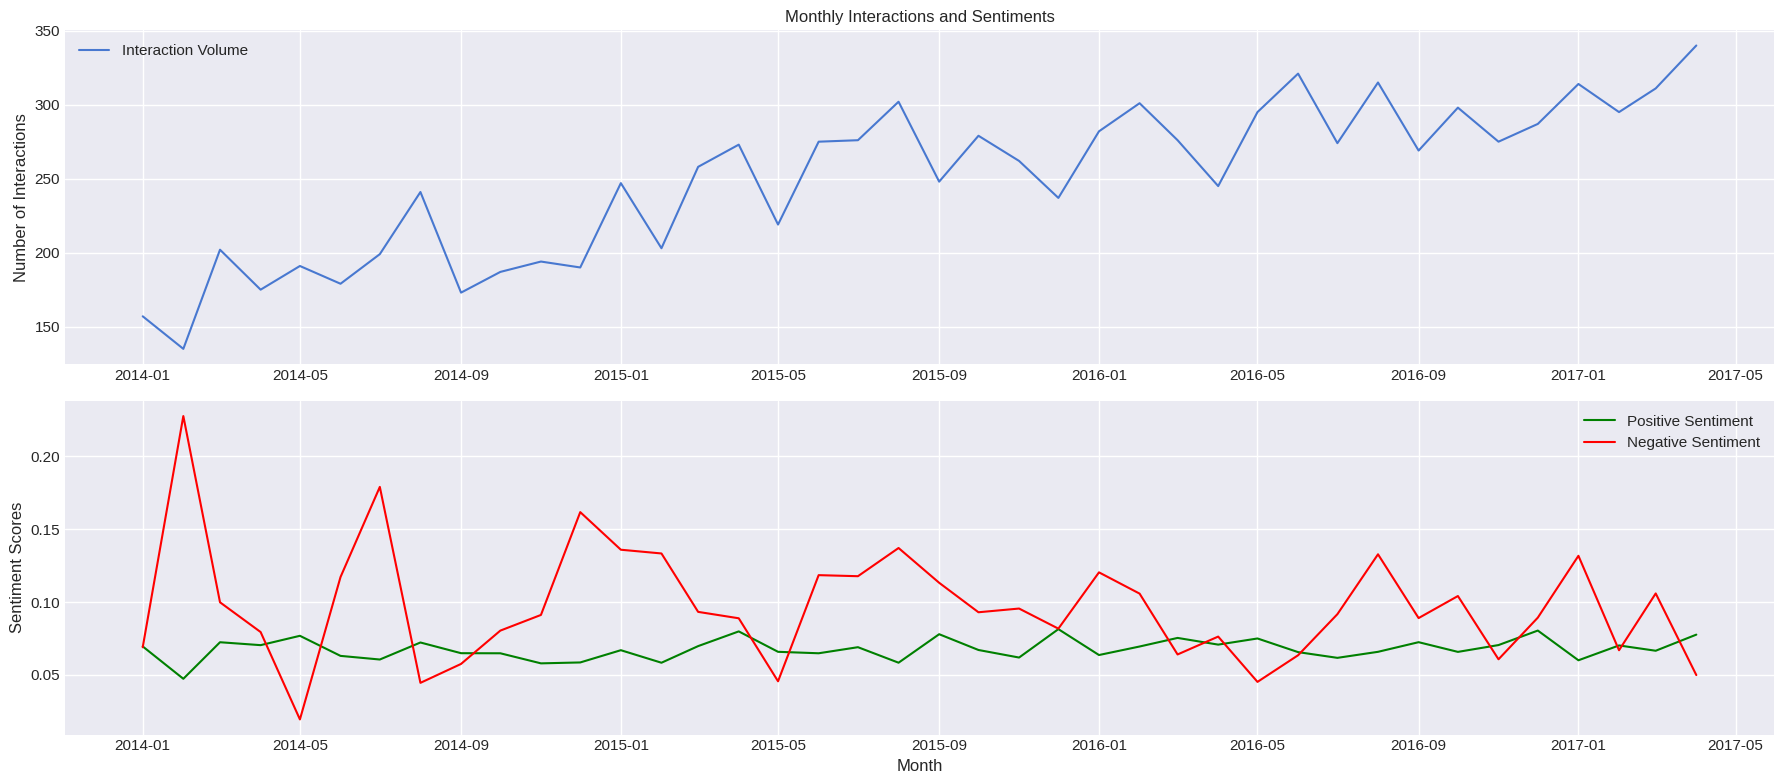

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

# Subplot 1: Interaction Volume Over Time
plt.subplot(2, 1, 1)
plt.plot(interaction_volume_df['Month'], interaction_volume_df['POST_ID'], label='Interaction Volume')
plt.title("Monthly Interactions and Sentiments")
plt.ylabel("Number of Interactions")
plt.legend()

# Subplot 2: Sentiment Scores Over Time
plt.subplot(2, 1, 2)
plt.plot(sentiment_df['Month'], sentiment_df['VADER_Positive'], label='Positive Sentiment', color='green')
plt.plot(sentiment_df['Month'], sentiment_df['VADER_Negative'], label='Negative Sentiment', color='red')
plt.xlabel("Month")
plt.ylabel("Sentiment Scores")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
print("Correlation between interaction volume and positive sentiment:", interaction_volume_df['POST_ID'].corr(sentiment_df['VADER_Positive']))
print("Correlation between interaction volume and negative sentiment:", interaction_volume_df['POST_ID'].corr(sentiment_df['VADER_Negative']))

Correlation between interaction volume and positive sentiment: 0.29965636531989237
Correlation between interaction volume and negative sentiment: -0.17874107247840998


The time-series visualization and correlation coefficients indicate a weak positive correlation between positive sentiment and interaction volume, alongside a weak negative correlation between negative sentiment and interaction volume. This suggests that other factors likely play a role in shaping sentiment scores across subreddit interactions.


Positive sentiment remains relatively stable over time, while negative sentiment experiences more noticeable fluctuations.

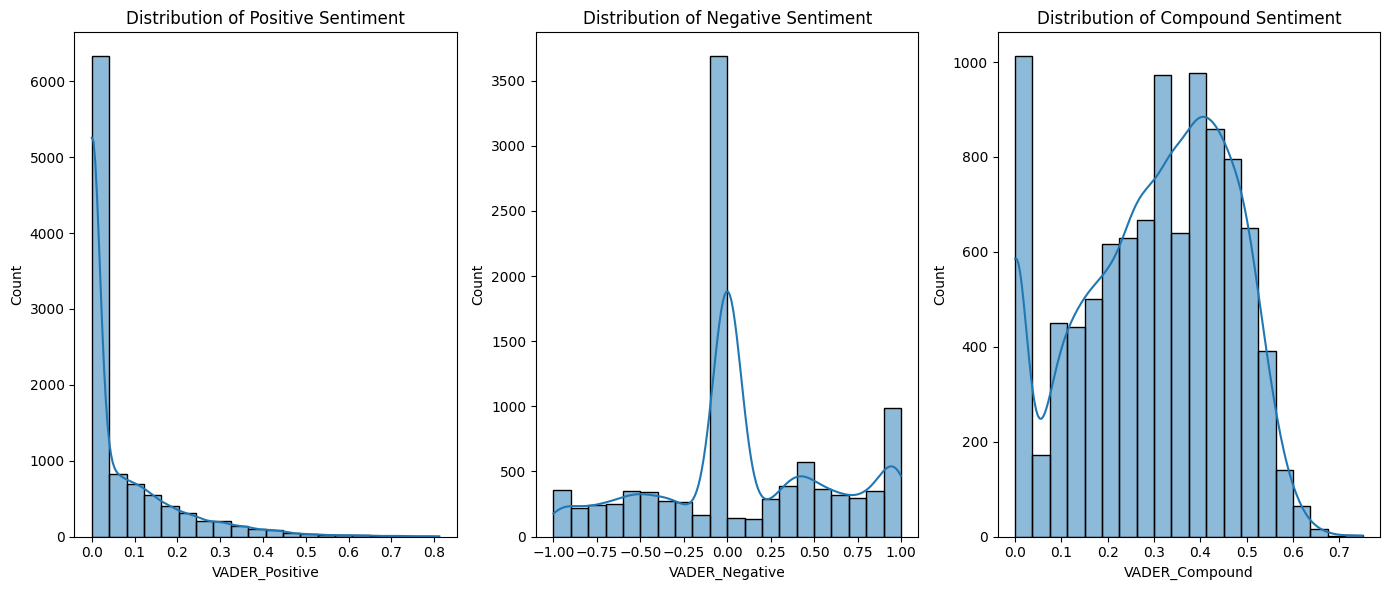

In [22]:
import seaborn as sns

plt.figure(figsize=(14, 6))

# Histogram for Positive Sentiment
plt.subplot(1, 3, 1)
sns.histplot(df_combined['VADER_Positive'], bins=20, kde=True)
plt.title("Distribution of Positive Sentiment")

# Histogram for Negative Sentiment
plt.subplot(1, 3, 2)
sns.histplot(df_combined['VADER_Negative'], bins=20, kde=True)
plt.title("Distribution of Negative Sentiment")

# Histogram for Compound Sentiment
plt.subplot(1, 3, 3)
sns.histplot(df_combined['VADER_Compound'], bins=20, kde=True)
plt.title("Distribution of Compound Sentiment")

plt.tight_layout()
plt.show()


The visualizations reveal the distributions of VADER sentiment scores for Reddit posts. The positive sentiment distribution shows a right-skewed pattern, with a significant peak at zero and a rapid decline thereafter, indicating that most posts convey minimal or no positive content. The negative sentiment distribution presents a bimodal shape, with a notable peak at zero and a secondary peak toward the positive side, suggesting that while many posts are neutral or slightly negative, a portion convey moderate to strong negativity. The compound sentiment distribution exhibits a near-normal distribution, skewed slightly towards the positive side, indicating a balanced mix of positive, negative, and neutral sentiment across posts.

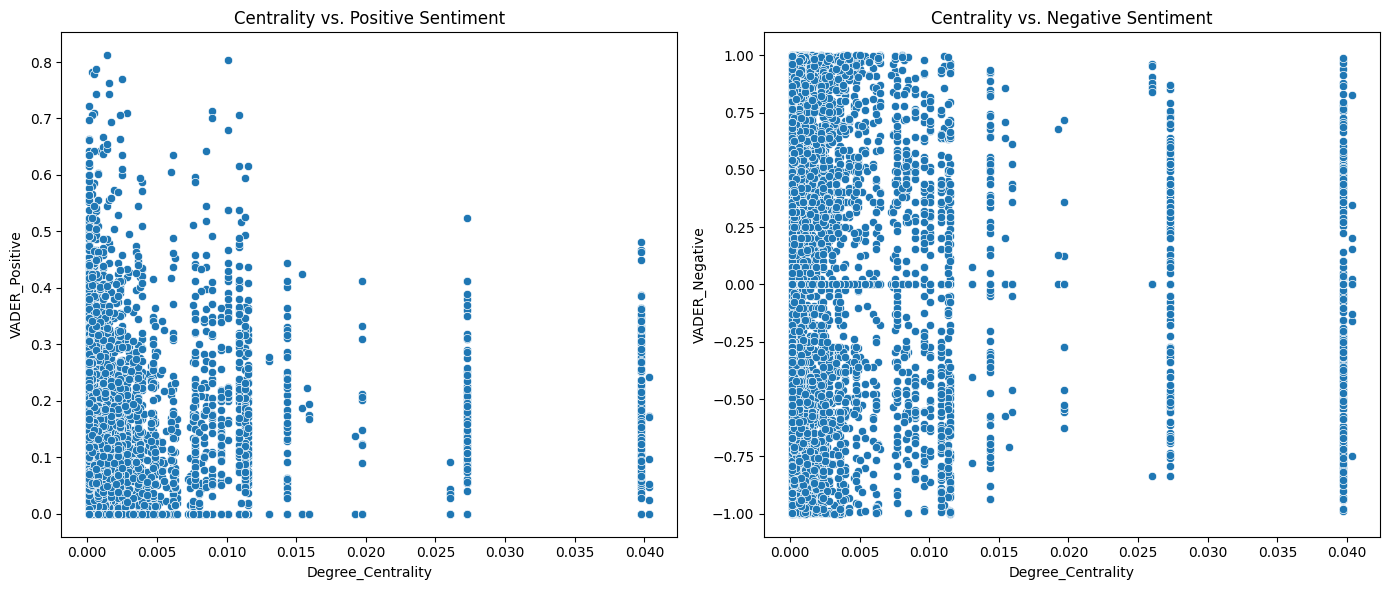

In [23]:
# Calculate node centrality measures (e.g., degree centrality)
centrality = nx.degree_centrality(G)
df_combined['Degree_Centrality'] = df_combined['SOURCE_SUBREDDIT'].map(centrality)

# Scatter plot of centrality vs. sentiment scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_combined, x='Degree_Centrality', y='VADER_Positive')
plt.title("Centrality vs. Positive Sentiment")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_combined, x='Degree_Centrality', y='VADER_Negative')
plt.title("Centrality vs. Negative Sentiment")

plt.tight_layout()
plt.show()

### Observations:

1. **Low Centrality, High Volume**:
   - **Both Plots**: Most points are clustered at lower centrality levels, showing that many subreddit interactions happen in communities that have fewer connections to others.
   - **Wide Sentiment Ranges**: Within this low-centrality cluster, positive and negative sentiment scores vary greatly, indicating that these communities exhibit a range of sentiment types in their posts.

2. **High Centrality, Low Volume**:
   - **Sparse High-Centrality Points**: As centrality increases, the number of points drops sharply, suggesting that only a few communities dominate the Reddit network's inter-community interactions.
   - **Sentiment Variety**: Despite their lower volume, high-centrality interactions show a range of positive and negative sentiment scores, indicating that even central communities exhibit varying post content.

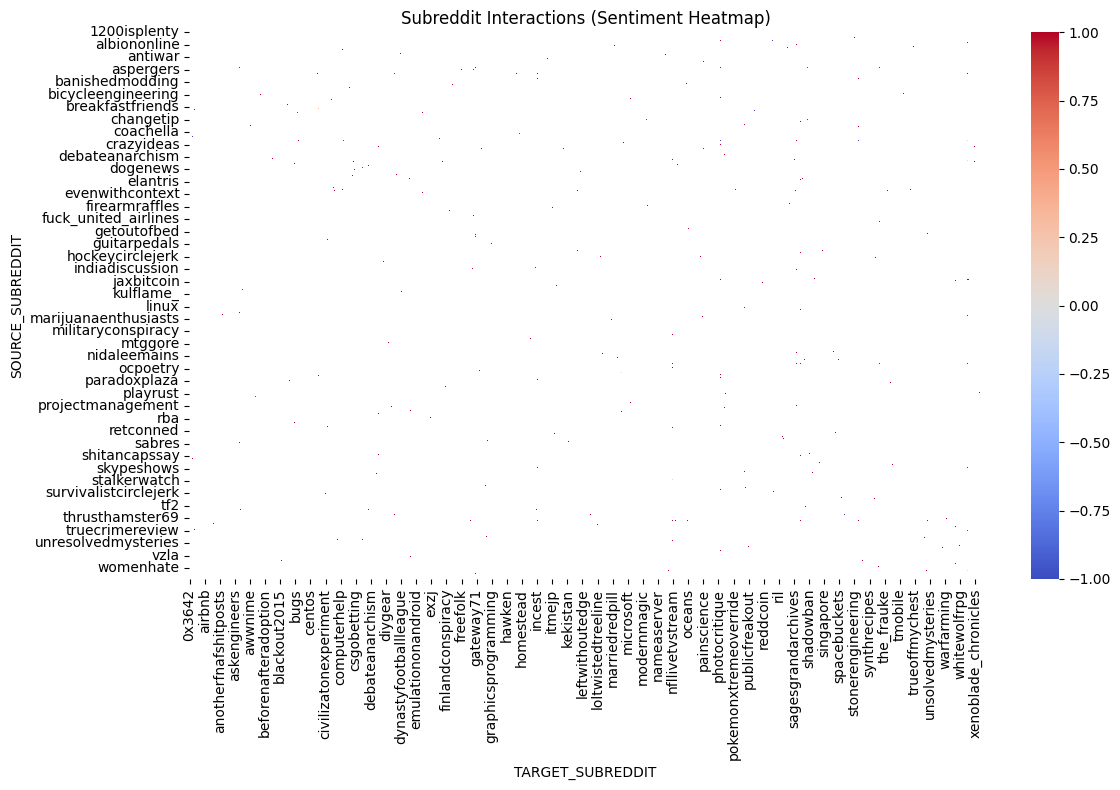

In [24]:
# Create a pivot table of interactions
pivot = df_combined.pivot_table(index='SOURCE_SUBREDDIT', columns='TARGET_SUBREDDIT', values='LINK_SENTIMENT', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='coolwarm')
plt.title("Subreddit Interactions (Sentiment Heatmap)")
plt.tight_layout()
plt.show()

### Observations:

The heatmap provides an overview of subreddit-to-subreddit interactions based on sentiment scores. Interactions are sparse, with positive and negative sentiments distributed throughout the listed subreddits. This suggests that subreddit interactions are concentrated in specific clusters and that no single sentiment type dominates.

In [36]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a graph from the combined dataset
G = nx.from_pandas_edgelist(df_combined, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Convert centrality measures to DataFrames
centrality_df = pd.DataFrame({
    'Subreddit': list(degree_centrality.keys()),
    'Degree_Centrality': list(degree_centrality.values()),
    'Betweenness_Centrality': list(betweenness_centrality.values()),
    'Closeness_Centrality': list(closeness_centrality.values())
})

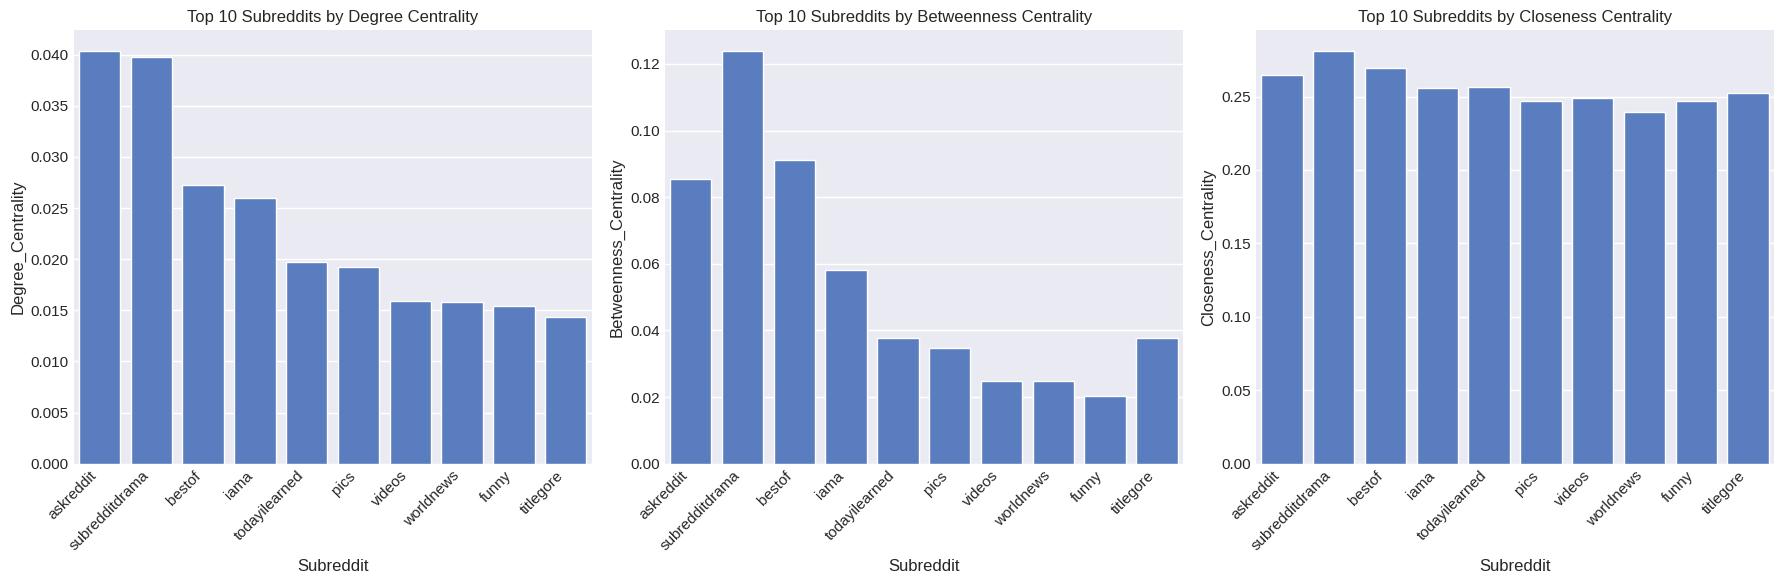

In [37]:
# Sort by degree centrality for plotting
centrality_df = centrality_df.sort_values(by='Degree_Centrality', ascending=False)

plt.figure(figsize=(18, 6))

# Plot Degree Centrality
plt.subplot(1, 3, 1)
sns.barplot(x=centrality_df['Subreddit'][:10], y=centrality_df['Degree_Centrality'][:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Subreddits by Degree Centrality")

# Plot Betweenness Centrality
plt.subplot(1, 3, 2)
sns.barplot(x=centrality_df['Subreddit'][:10], y=centrality_df['Betweenness_Centrality'][:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Subreddits by Betweenness Centrality")

# Plot Closeness Centrality
plt.subplot(1, 3, 3)
sns.barplot(x=centrality_df['Subreddit'][:10], y=centrality_df['Closeness_Centrality'][:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Subreddits by Closeness Centrality")

plt.tight_layout()
plt.show()

**Cluster and Community Detection:**
   - **Girvan-Newman vs. Greedy Modularity:**
      - Applying both algorithms to detect communities in the network and comparing their results using metrics such as the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).



In [53]:
from networkx.algorithms.community import greedy_modularity_communities

# Detect communities using modularity maximization
communities = greedy_modularity_communities(G)

# Map communities to nodes
community_map = {node: idx for idx, community in enumerate(communities) for node in community}

# Convert to a DataFrame
df_combined['Community'] = df_combined['SOURCE_SUBREDDIT'].map(community_map)

In [54]:
import numpy as np
# Convert to labels
modularity_labels = np.array([community_map.get(node, -1) for node in G.nodes()])

In [39]:
import plotly.graph_objects as go

# Create a graph from the combined dataset
G = nx.from_pandas_edgelist(df_combined, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Detect communities
communities = greedy_modularity_communities(G)

# Map communities to nodes
community_map = {node: idx for idx, community in enumerate(communities) for node in community}

# Create positions using a spring layout
pos = nx.spring_layout(G, scale=1)

# Extract edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create nodes
node_x = []
node_y = []
node_colors = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_colors.append(community_map.get(node, 0))
    node_text.append(f"Subreddit: {node}, Community: {community_map.get(node, 0)}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=node_colors,
        size=8,
        colorbar=dict(thickness=15, title='Community', xanchor='left', titleside='right')
    ),
    text=node_text
)

# Create final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Network Visualization with Communities',
                                 showlegend=False,
                                 hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [40]:
from networkx.algorithms.community import greedy_modularity_communities

# Detect communities using modularity maximization
communities = greedy_modularity_communities(G)

# Number of communities
num_communities = len(communities)

print(f"Number of communities formed: {num_communities}")

Number of communities formed: 853


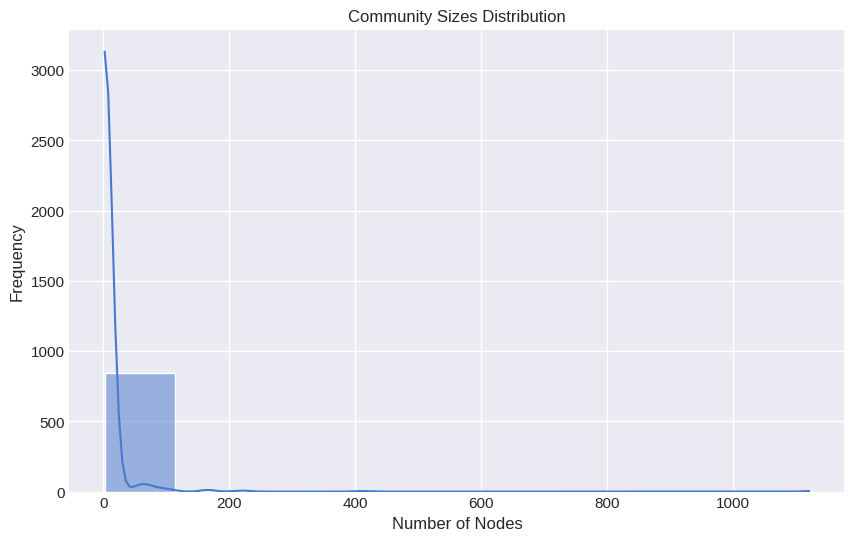

In [41]:
community_sizes = [len(community) for community in communities]

plt.figure(figsize=(10, 6))
sns.histplot(community_sizes, bins=10, kde=True)
plt.title("Community Sizes Distribution")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")
plt.show()

### Community Detection Algorithm:
The algorithm used is the `greedy_modularity_communities`:

1. **Modularity Maximization**:
   - The algorithm aims to maximize modularity, a measure of the strength of divisions between communities.
   - Modularity calculates how much more dense connections are within communities than between them.

2. **Greedy Approach**:
   - The algorithm iteratively merges communities to increase modularity, leading to a clustering where intra-community connections are maximized.

3. **Effectiveness**:
   - This algorithm is effective for identifying clusters in networks like Reddit, revealing groups of subreddits that frequently interact with each other.

#### Observations:
1. **Highly Skewed Distribution**:
   - The histogram shows a steep drop-off, with most communities having few nodes.
   - This indicates that many communities in the Reddit network are relatively small, containing only a handful of subreddits.

2. **Large Communities Are Rare**:
   - The distribution shows very few communities with more than 200 nodes, suggesting that large communities are a rarity in the Reddit network.

3. **Network Fragmentation**:
   - The presence of many small communities indicates that the Reddit network is highly fragmented, with individual clusters of subreddits often operating independently of others.

In [42]:
# Sort communities by size and select the top 50
top_50_communities = sorted(communities, key=len, reverse=True)[:50]

# Create a new community map for these 50 communities
top_50_community_map = {node: idx for idx, community in enumerate(top_50_communities) for node in community}

In [43]:
def visualize_community(G, community_map, community_idx):
    # Filter nodes belonging to the specified community
    nodes_in_community = [node for node, idx in community_map.items() if idx == community_idx]

    # Subgraph for the specific community
    subG = G.subgraph(nodes_in_community)

    # Create positions for the nodes
    pos = nx.spring_layout(subG, scale=1)

    # Extract edges
    edge_x = []
    edge_y = []
    for edge in subG.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    # Create nodes
    node_x = []
    node_y = []
    node_text = []

    for node in subG.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"Subreddit: {node}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            size=8,
            color='blue'
        ),
        text=node_text
    )

    # Create final figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(title=f'Community {community_idx} Visualization',
                                     showlegend=False,
                                     hovermode='closest',
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    fig.show()

# Visualize specific communities
visualize_community(G, top_50_community_map, 0)
visualize_community(G, top_50_community_map, 1)

In [50]:
from networkx.algorithms.community import girvan_newman

# Apply the Girvan-Newman algorithm
girvan_newman_communities = girvan_newman(G)

# Take the first partition
first_gn_partition = next(girvan_newman_communities)

# Map communities to nodes
gn_community_map = {node: idx for idx, community in enumerate(first_gn_partition) for node in community}

# Convert to labels
gn_labels = np.array([gn_community_map.get(node, -1) for node in G.nodes()])

In [51]:
import plotly.graph_objects as go

# Create positions for the nodes
pos = nx.spring_layout(G)

# Extract edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create nodes
node_x = []
node_y = []
node_colors = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_colors.append(gn_community_map.get(node, 0))
    node_text.append(f"Subreddit: {node}, Community: {gn_community_map.get(node, 0)}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=node_colors,
        size=8,
        colorbar=dict(thickness=15, title='Community', xanchor='left', titleside='right')
    ),
    text=node_text
)

# Create the final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Girvan-Newman Community Visualization',
                                 showlegend=False,
                                 hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [62]:
from sklearn.metrics import adjusted_rand_score

# Compare Girvan-Newman clusters to Greedy Modularity clusters
ari_score = adjusted_rand_score(modularity_labels, gn_labels)
print(f"Adjusted Rand Index (Girvan-Newman vs Greedy Modularity): {ari_score}")

Adjusted Rand Index (Girvan-Newman vs Greedy Modularity): 0.06484022783078687


In [65]:
from sklearn.metrics import normalized_mutual_info_score

# Compare the clustering results between the two algorithms
nmi_score = normalized_mutual_info_score(modularity_labels, gn_labels)
print(f"Normalized Mutual Information Score: {nmi_score}")

Normalized Mutual Information Score: 0.6091836382572164


### Comparison of Community Detection Algorithms:

1. **Normalized Mutual Information Score**:
   - **Value**: 0.61
   - **Explanation**: NMI measures how much information is shared between two sets of labels, ranging from 0 to 1. A score of 0.61 indicates a moderate to strong degree of similarity between the communities identified by the Girvan-Newman and Greedy Modularity algorithms.
   - **Inference**: This suggests that while the two algorithms use different approaches, they identify overlapping communities, reflecting a degree of consistency in their clustering.

2. **Adjusted Rand Index**:
   - **Value**: 0.06484022783078687
   - **Explanation**: ARI measures the similarity between two clustering results, ranging from -1 to 1. A score of 0.065 indicates a low degree of agreement between the communities identified by the two algorithms.
   - **Inference**: The low ARI score indicates that despite a moderate to strong information overlap, the two algorithms produce structurally distinct communities, likely due to differences in their detection mechanisms.

### Conclusion:
The NMI score shows a moderate information overlap between the communities detected by Girvan-Newman and Greedy Modularity algorithms, but the low ARI indicates that these algorithms produce distinct clusters in terms of structure. This reflects the differing mechanisms of these algorithms:
- **Girvan-Newman**: Splits the network by removing edges with high betweenness centrality, resulting in a hierarchical structure.
- **Greedy Modularity**: Iteratively merges communities to maximize intra-community density

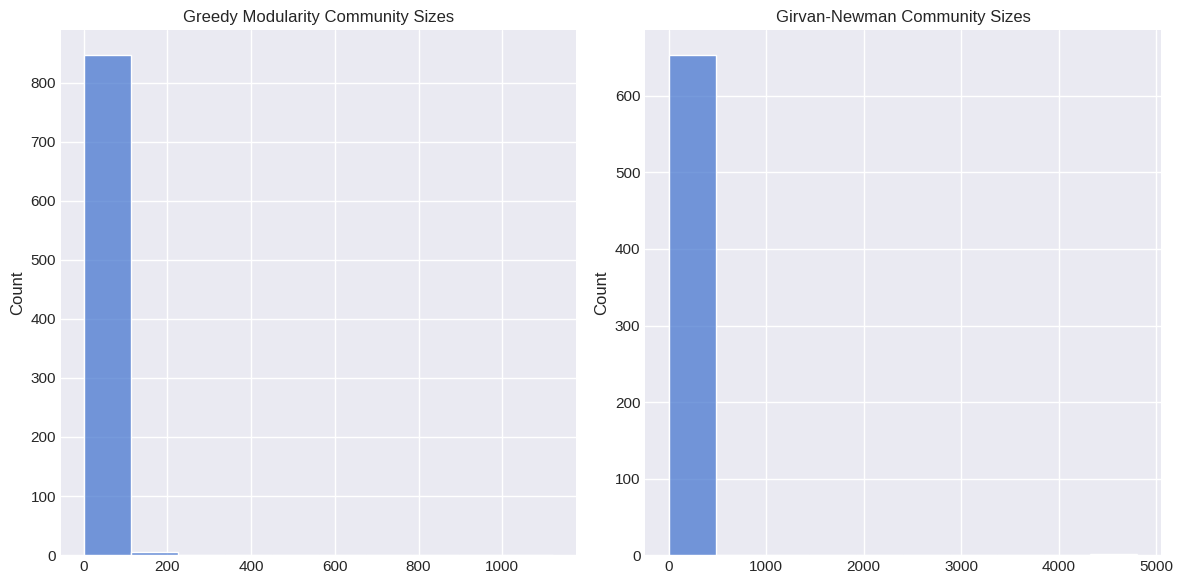

In [58]:
modularity_sizes = [len(community) for community in communities]
gn_sizes = [len(community) for community in first_gn_partition]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(modularity_sizes, bins=10)
plt.title("Greedy Modularity Community Sizes")

plt.subplot(1, 2, 2)
sns.histplot(gn_sizes, bins=10)
plt.title("Girvan-Newman Community Sizes")

plt.tight_layout()
plt.show()

**ML-Based Clustering:**
   - **K-Means and DBSCAN:**
      - Applies these machine learning algorithms to cluster nodes based on their centrality measures, comparing their results to community detection algorithms.

In [76]:
import pandas as pd
import numpy as np
import networkx as nx

# Filter or sample the dataset
df_combined_sample = df_combined.sample(n=5000, random_state=42)

# Create a graph from this sample
G = nx.from_pandas_edgelist(df_combined_sample, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Create the adjacency matrix
adjacency_matrix = nx.to_numpy_array(G)

# Centrality measures
degree_centrality = list(nx.degree_centrality(G).values())
betweenness_centrality = list(nx.betweenness_centrality(G).values())
closeness_centrality = list(nx.closeness_centrality(G).values())

# Create a DataFrame for centrality measures
centrality_df = pd.DataFrame({
    'Degree_Centrality': degree_centrality,
    'Betweenness_Centrality': betweenness_centrality,
    'Closeness_Centrality': closeness_centrality
})

In [77]:
# Check shapes before combining
print(f"Adjacency matrix shape: {adjacency_matrix.shape}")
print(f"Centrality DataFrame shape: {centrality_df.shape}")

# Ensure matching row counts
if adjacency_matrix.shape[0] == centrality_df.shape[0]:
    feature_matrix = np.hstack([adjacency_matrix, centrality_df.to_numpy()])
else:
    print("Mismatch in row counts between adjacency matrix and centrality DataFrame")

Adjacency matrix shape: (4050, 4050)
Centrality DataFrame shape: (4050, 3)


In [78]:
# Convert the centrality DataFrame to a numpy array
centrality_array = centrality_df.to_numpy()

# Concatenate the feature matrix by combining the adjacency matrix and the centrality array
feature_matrix = np.hstack([adjacency_matrix, centrality_array])

In [79]:
from sklearn.cluster import KMeans, DBSCAN

# K-means clustering with a chosen number of clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(feature_matrix)
kmeans_labels = kmeans.labels_

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(feature_matrix)
dbscan_labels = dbscan.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



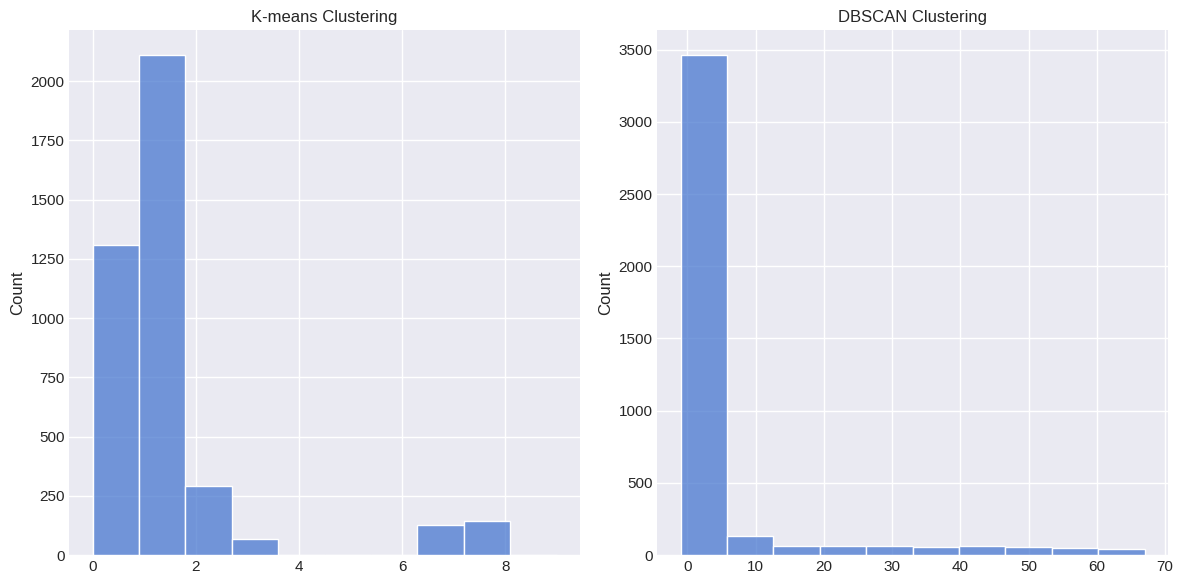

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Visualize K-means clusters
plt.subplot(1, 2, 1)
sns.histplot(kmeans_labels, bins=10)
plt.title("K-means Clustering")

# Visualize DBSCAN clusters
plt.subplot(1, 2, 2)
sns.histplot(dbscan_labels, bins=10)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [81]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Compare to existing community detection labels
community_labels = np.array([community_map.get(node, -1) for node in G.nodes()])

# Compare K-means to community detection
kmeans_ari = adjusted_rand_score(community_labels, kmeans_labels)
kmeans_nmi = normalized_mutual_info_score(community_labels, kmeans_labels)
print(f"K-means vs Community Detection - ARI: {kmeans_ari}, NMI: {kmeans_nmi}")

# Compare DBSCAN to community detection
dbscan_ari = adjusted_rand_score(community_labels, dbscan_labels)
dbscan_nmi = normalized_mutual_info_score(community_labels, dbscan_labels)
print(f"DBSCAN vs Community Detection - ARI: {dbscan_ari}, NMI: {dbscan_nmi}")

K-means vs Community Detection - ARI: 0.014621844882467072, NMI: 0.18084377475977478
DBSCAN vs Community Detection - ARI: -0.016757931970586167, NMI: 0.19463960102234956


### K-means vs Community Detection:

1. **Adjusted Rand Index (ARI)**:
   - **Value**: 0.014621844882467072
   - **Explanation**: ARI measures the degree of agreement between two clustering solutions. The range is from -1 to 1, with a positive score indicating some agreement.
   - **Inference**: This score indicates very little agreement between the communities identified by K-means and those identified by the Greedy Modularity algorithm.

2. **Normalized Mutual Information (NMI)**:
   - **Value**: 0.18084377475977478
   - **Explanation**: NMI measures how much information is shared between two clustering solutions, ranging from 0 to 1.
   - **Inference**: This score suggests some shared information, but highlights substantial differences in how K-means and Greedy Modularity algorithms cluster the Reddit network.

### DBSCAN vs Community Detection:

1. **Adjusted Rand Index (ARI)**:
   - **Value**: -0.016757931970586167
   - **Explanation**: A negative ARI indicates disagreement between the DBSCAN clustering results and the community detection labels.
   - **Inference**: This indicates that DBSCAN's clustering differs significantly from the community detection.

2. **Normalized Mutual Information (NMI)**:
   - **Value**: 0.19463960102234956
   - **Explanation**: A moderate NMI suggests some shared information between the two clustering solutions.
   - **Inference**: Despite the disagreement reflected in the ARI, the NMI shows some overlap between DBSCAN's and Greedy Modularity's clustering.

## *Text based Sentiment Analysis*

In [82]:
import pandas as pd
import numpy as np
from textblob import TextBlob

# Define a function to check for offensive language
def check_offensive_language(subreddit_name):
    # Create a text blob from the subreddit name
    blob = TextBlob(subreddit_name)
    # Check sentiment polarity
    sentiment = blob.sentiment.polarity

    # Flag as offensive if sentiment is negative
    if sentiment < 0:
        return True
    return False

# Applying the function to both source and target subreddits
df_combined['Source_Offensive'] = df_combined['SOURCE_SUBREDDIT'].apply(check_offensive_language)
df_combined['Target_Offensive'] = df_combined['TARGET_SUBREDDIT'].apply(check_offensive_language)

# Display a sample of the dataset
display(df_combined[['SOURCE_SUBREDDIT', 'Source_Offensive', 'TARGET_SUBREDDIT', 'Target_Offensive']].head())

SOURCE_SUBREDDIT  Source_Offensive TARGET_SUBREDDIT  Target_Offensive
0   vaingloryleaks             False    vainglorygame             False
1    denvernuggets             False            kings             False
2           movies             False           flicks             False
3    60teams60days             False    collegehockey             False
4       indyeleven             False       naslsoccer             False

In [84]:
import pandas as pd

# Display rows where the source or target subreddits are flagged as offensive
offensive_df = df_combined[(df_combined['Source_Offensive']) | (df_combined['Target_Offensive'])]

# Display a sample of these rows
display(offensive_df[['SOURCE_SUBREDDIT', 'Source_Offensive', 'TARGET_SUBREDDIT', 'Target_Offensive', 'VADER_Positive', 'VADER_Negative']].head())

SOURCE_SUBREDDIT  Source_Offensive TARGET_SUBREDDIT  Target_Offensive  \
48               spam             False              wtf              True   
458       findareddit             False              wtf              True   
730          military              True       theredpill             False   
900          military              True             army             False   
1232              arg             False           creepy              True   

      VADER_Positive  VADER_Negative  
48             0.000          0.0000  
458            0.107          0.2960  
730            0.108         -0.8658  
900            0.000          0.8720  
1232           0.019         -0.4606

In [91]:
from sklearn.preprocessing import LabelEncoder

# Define a function to check for offensive language
def check_offensive_language(subreddit_name):
    blob = TextBlob(subreddit_name)
    sentiment = blob.sentiment.polarity

    return sentiment < 0  # Flag as offensive if sentiment is negative

# Define a function to vectorize offensiveness
def vectorize_offensive(subreddit_name):
    return 1 if check_offensive_language(subreddit_name) else 0

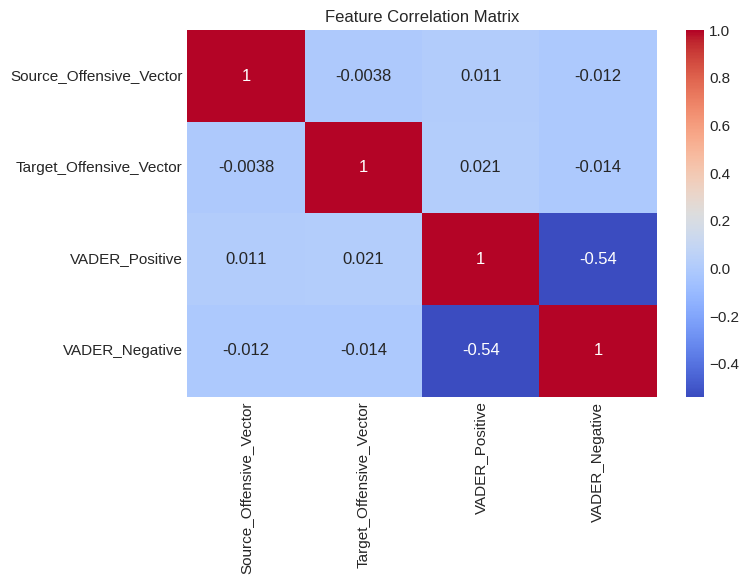

In [93]:
# Compute correlations
corr = df_combined[['Source_Offensive_Vector', 'Target_Offensive_Vector', 'VADER_Positive', 'VADER_Negative']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### Correlation Matrix Interpretation:

- **Minimal Relationship**: The offensiveness of subreddit names (both source and target) shows negligible correlations with VADER sentiment scores, suggesting that offensiveness in names does not directly relate to post sentiment.
- **Inverse Sentiment Relationship**: The negative correlation between `VADER_Positive` and `VADER_Negative` indicates an inverse relationship, as expected between positive and negative sentiments.

**Role Classification:**
    - Classifying nodes into attackers, defenders, and neutrals based on VADER compound scores or the `LINK_SENTIMENT` field.

    - Node colors and hover text reflect their role or sentiment score.

In [101]:
def classify_link_sentiment(row):
    if row['LINK_SENTIMENT'] == -1:
        return 'Attacker'
    elif row['LINK_SENTIMENT'] == 1:
        return 'Defender'
    else:
        return 'Neutral'

# Choose and apply a classification function
df_combined['Role'] = df_combined.apply(classify_link_sentiment, axis=1)  # or use classify_link_sentiment

In [102]:
subreddit_roles = df_combined.groupby('SOURCE_SUBREDDIT')['Role'].agg(lambda x: x.mode()[0])

In [104]:
import networkx as nx
import plotly.graph_objects as go

# Create a graph from the dataset
G = nx.from_pandas_edgelist(df_combined, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Create positions for nodes
pos = nx.spring_layout(G)

# Extract edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create nodes
node_x = []
node_y = []
node_colors = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

    # Map roles to colors
    role = subreddit_roles.get(node, 'Neutral')
    role_color = {'Attacker': 2, 'Defender': 1, 'Neutral': 0}.get(role, 0)
    node_colors.append(role_color)

    node_text.append(f"Subreddit: {node}, Role: {role}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlOrRd',
        color=node_colors,
        size=8,
        colorbar=dict(thickness=15, title='Role', xanchor='left', titleside='right')
    ),
    text=node_text
)

# Create the final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Subreddit Network with Roles',
                                 showlegend=False,
                                 hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

# Save as an HTML file
fig.write_html("subreddit_network_roles.html")


5. **Simulation Models:**
   - **Random Network:**
      - Creating an Erdős - Rényi model with the same number of nodes as the Reddit dataset, connecting pairs with a fixed probability.
   - **Preferential Attachment Network:**
      - Using the Barabási - Albert model to create a scale-free network, where nodes preferentially attach to higher-degree nodes.

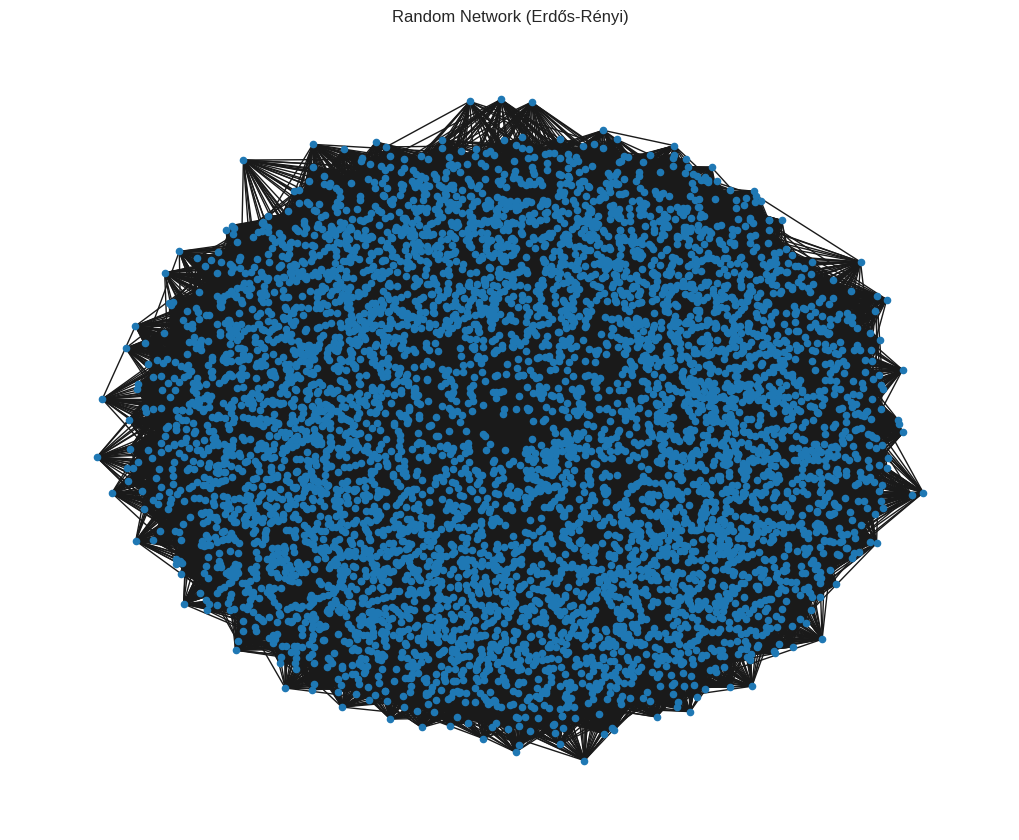

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

# Number of nodes
num_nodes = len(set(df_combined['SOURCE_SUBREDDIT']).union(set(df_combined['TARGET_SUBREDDIT'])))

# Probability of edge creation
edge_prob = 0.01  # Can adjust based on density requirements

# Generate random network
random_G = nx.erdos_renyi_graph(num_nodes, edge_prob)

# Visualize
plt.figure(figsize=(10, 8))
nx.draw(random_G, node_size=20)
plt.title("Random Network (Erdős-Rényi)")
plt.show()

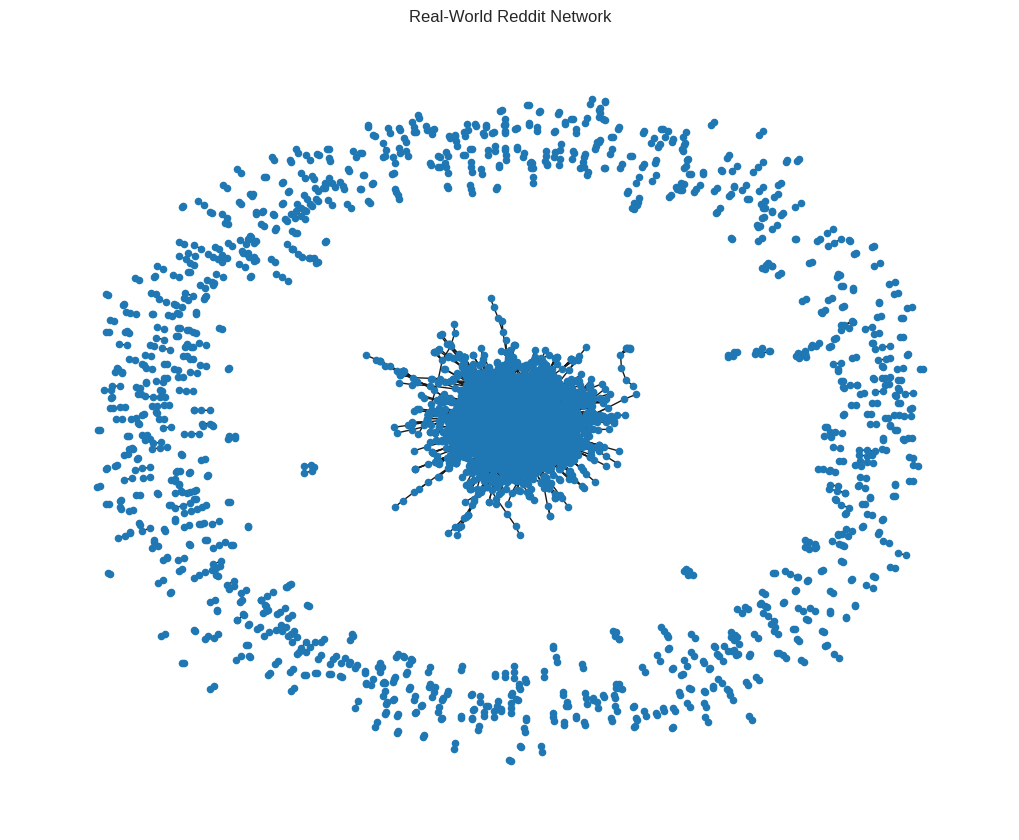

In [106]:
# Create a network from the dataset
real_world_G = nx.from_pandas_edgelist(df_combined, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')

# Visualize
plt.figure(figsize=(10, 8))
nx.draw(real_world_G, node_size=20)
plt.title("Real-World Reddit Network")
plt.show()

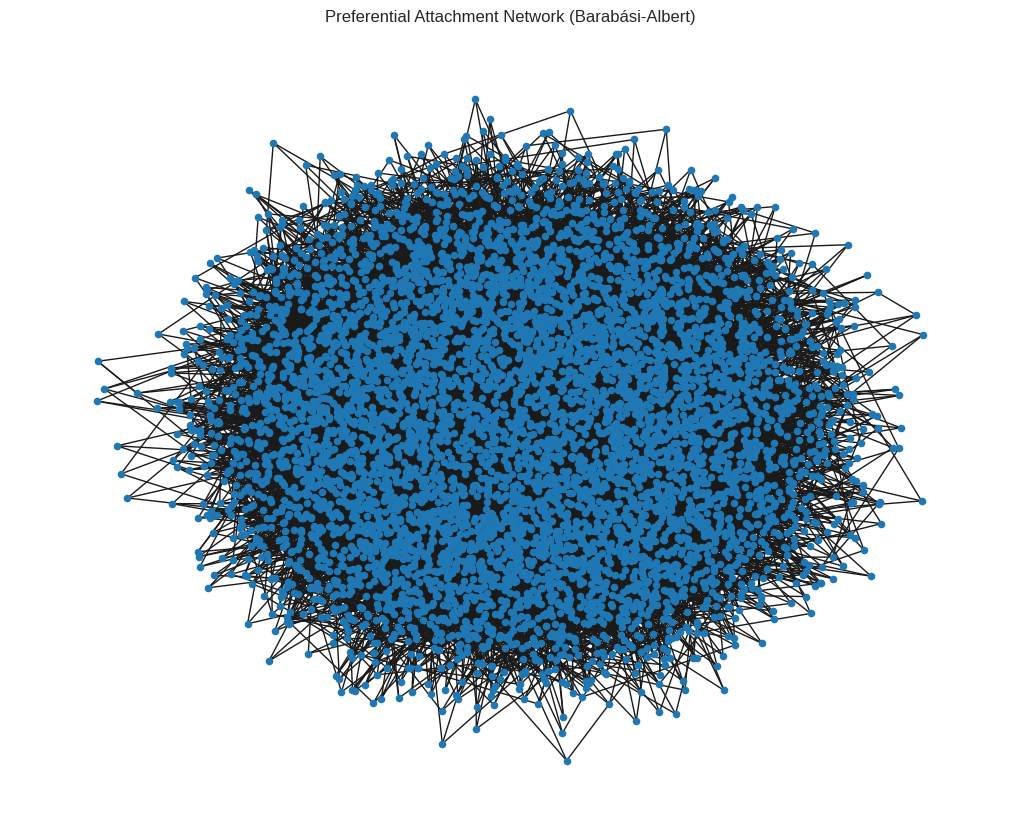

In [107]:
# Generate a scale-free network
ba_G = nx.barabasi_albert_graph(num_nodes, m=3)  # m is the number of edges added per new node

# Visualize
plt.figure(figsize=(10, 8))
nx.draw(ba_G, node_size=20)
plt.title("Preferential Attachment Network (Barabási-Albert)")
plt.show()

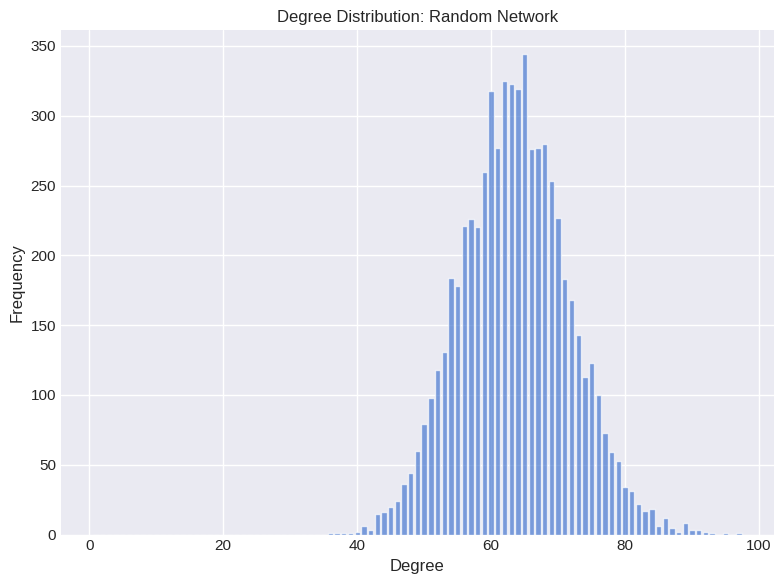

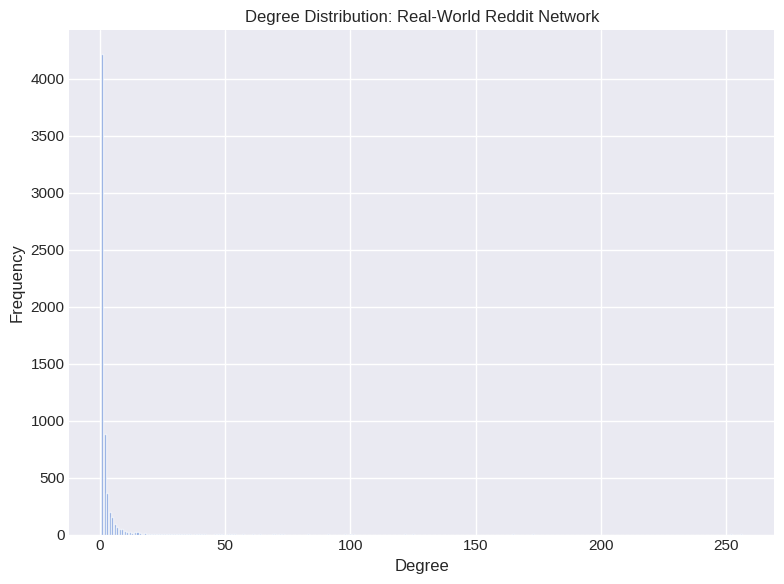

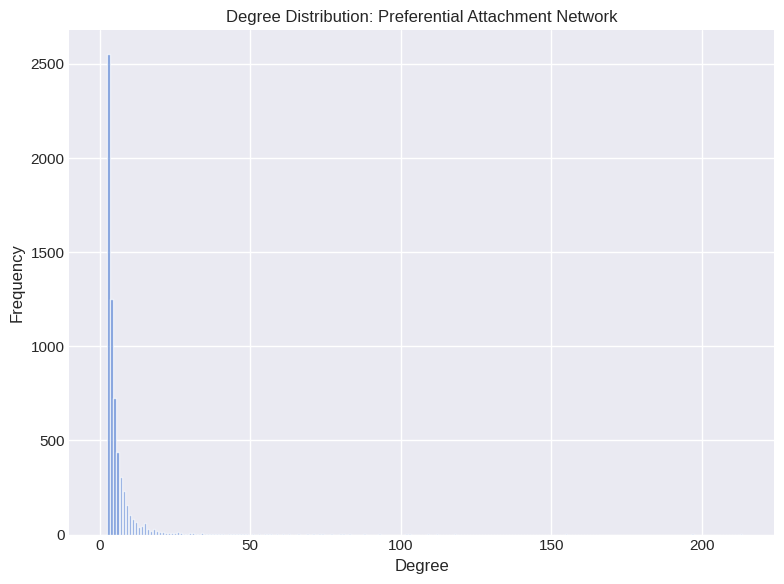

In [108]:
import numpy as np

# Degree distribution function
def plot_degree_distribution(G, title):
    degrees = [deg for _, deg in G.degree()]
    hist, bins = np.histogram(degrees, bins=range(1, max(degrees) + 2))

    plt.figure(figsize=(8, 6))
    plt.bar(bins[:-1], hist, width=0.8, alpha=0.7, color='b')
    plt.title(f"Degree Distribution: {title}")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot degree distributions
plot_degree_distribution(random_G, "Random Network")
plot_degree_distribution(real_world_G, "Real-World Reddit Network")
plot_degree_distribution(ba_G, "Preferential Attachment Network")


In [109]:
# Clustering coefficients
random_cc = nx.average_clustering(random_G)
real_world_cc = nx.average_clustering(real_world_G)
ba_cc = nx.average_clustering(ba_G)

print(f"Random Network Clustering Coefficient: {random_cc}")
print(f"Real-World Reddit Network Clustering Coefficient: {real_world_cc}")
print(f"Preferential Attachment Network Clustering Coefficient: {ba_cc}")

Random Network Clustering Coefficient: 0.009966557558074927
Real-World Reddit Network Clustering Coefficient: 0.03132522437174715
Preferential Attachment Network Clustering Coefficient: 0.007216073967898369


### Degree Distributions:

1. **Random Network:**
   - **Distribution:** Forms a symmetric distribution around the mean.
   - **Inference:** Reflects a binomial-like degree distribution, typical for a random network where each edge is created independently with a fixed probability.
   - **Nodes:** Cluster around an average degree, with fewer nodes having significantly high or low degrees.

2. **Real-World Reddit Network:**
   - **Distribution:** Highly skewed, with many nodes having low degrees and a few nodes with significantly higher degrees.
   - **Inference:** Suggests a scale-free structure, where some nodes act as hubs with high connectivity.
   - **Behavior:** Mirrors real-world networks, where a few nodes (subreddits) dominate connectivity.

3. **Preferential Attachment Network:**
   - **Distribution:** Similar skewed distribution to the real-world Reddit network.
   - **Inference:** Indicates that new nodes are preferentially attaching to high-degree nodes, forming a scale-free structure.
   - **Behavior:** Aligns with real-world network structures and provides a closer approximation than the random model.

### Overall Insights:

1. **Real-World Network Comparison:**
   - The real-world Reddit network shows higher clustering and skewed degree distribution, indicating community structures and hub nodes.
  
2. **Preferential Attachment:**
   - Closely mirrors real-world structures with its skewed degree distribution, but has lower transitivity, suggesting a need for combined modeling approaches.

3. **Random Network:**
   - Acts as a baseline, showing how independent edge creation differs significantly from real-world and preferential networks.